# Intro/title here

In [68]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Processing

In [69]:
#Import the finite market model functionality from the PortfolioBase notebook
%pip install nbformat
%run PortfolioBase.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
import numpy as np
import pandas as pd
import csv
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import wasserstein_distance


import matplotlib.pyplot as plt

In [71]:

file = open("FTSE100.tickers")
iter = csv.reader(file, delimiter='\n')

tickers = []
train_stocks = {}
validate_stocks = {}
test_stocks = {}

for ticker in iter:
    tickers=tickers+[ticker[0].split(".")[0]]

# We use an 80:10:10 split for train-validate-test
# The split is ordered temporally to avoid model leakage
for tick in tickers:
    stockData = pd.read_csv(f"HistoricPrices/{tick}.csv", header = 0, names=("Day", "Price"))
    train_stocks[tick], further_stocks = np.split(stockData, [int(.80 *len(stockData))])
    validate_stocks[tick], test_stocks[tick] = np.split(further_stocks, [int(.50 *len(further_stocks))])


C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return b

In [72]:
def estimateClassProbsFromSample(preds,classes):
    probs = []
    for i in range(classes):
        probs.append(np.count_nonzero(preds == float(i))/len(preds))
    return probs

#Use the mean element as a representitive of the cluster (could have also have used the median)
def calculateCentralClassElement(x, preds, classes):
    sizes = {x:0 for x in range(classes)}
    cumulative = {x:0 for x in range(classes)}
    for i in range(len(x)):
        assignedClass = int(preds[i])
        sizes[assignedClass] += 1
        cumulative[assignedClass] += x[i]
    return [cumulative[i]/sizes[i] for i in range(classes)]

def calculateChange(data, type):
    if type == "percentage":
        return (data["Price"]/data["Price"].shift()).dropna()
    elif type == "abs":
        return data.diff().dropna()["Price"]
    else:
        raise("Type is not supported")

# Time Series Analysis


In [73]:
timeSeriesPC = {}
for i in range(len(tickers)):
    timeSeriesPC[tickers[i]] = calculateChange(train_stocks[tickers[i]], "percentage")

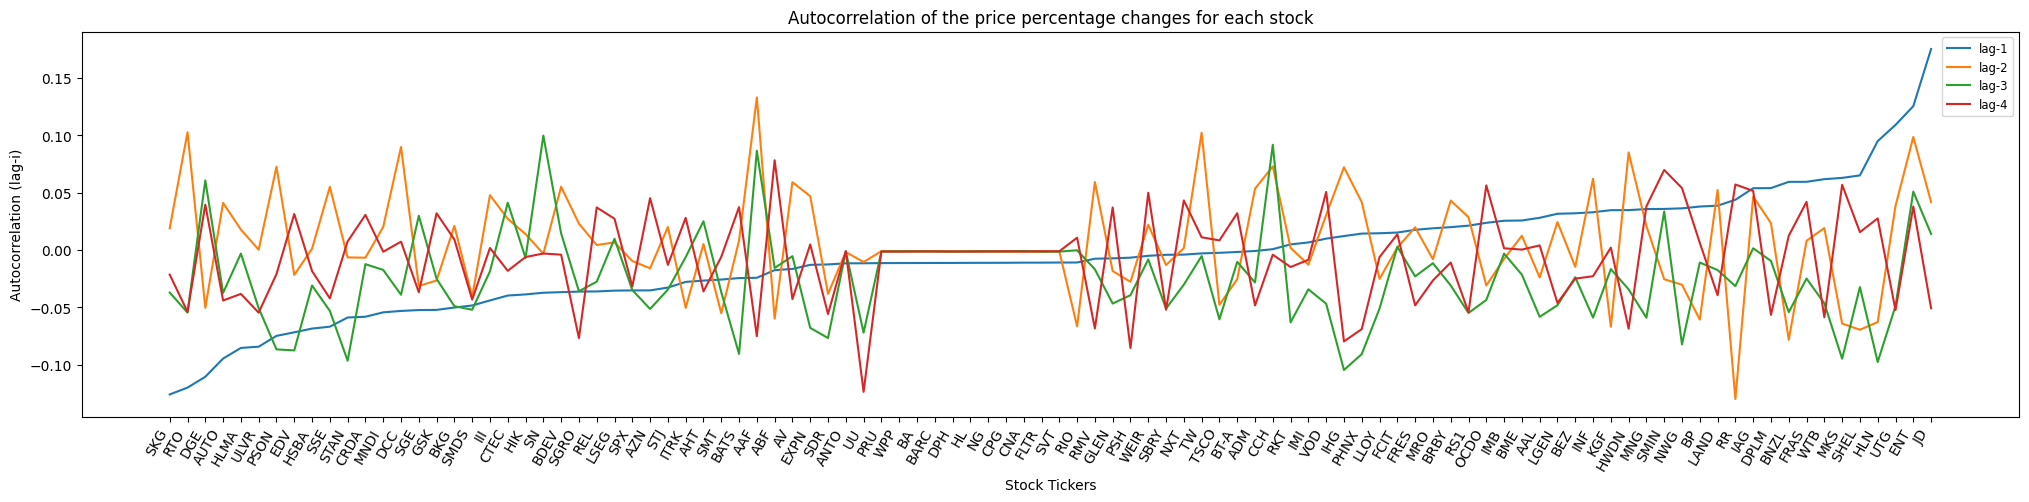

In [74]:
acf = []
lags = 5
for i in range(len(tickers)):
    pcACF = []
    for h in range(1,lags):
        pcACF.append(timeSeriesPC[tickers[i]].autocorr(lag=h))
    acf.append([np.array(pcACF), tickers[i]])

def distSort(e):
    return float(e[0][0])

acf.sort(key=distSort)
sTickers = []
sDistances = []
for item in acf:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
# The stocks are ordered from lowest lag1 autocorrelation to highest.
# Stocks labeled on the x axis aren't exhaustive and displayed to gain a feel for each stock
plt.title("Autocorrelation of the price percentage changes for each stock")
plt.ylabel("Autocorrelation (lag-i)")
plt.xlabel("Stock Tickers")


for i in range(lags-1):
    plt.plot(sTickers, np.array(sDistances)[:,i], label=f"lag-{str(i+1)}")
plt.legend(fontsize = "small")

plt.rcParams["figure.figsize"] = (25,5)
plt.xticks(rotation=60, ha='right')

plt.savefig("Images/PC-Series-ACF.svg")

plt.show()

In [75]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
Ljung–Box test


In [132]:
#Stationarity
from statsmodels.tsa.stattools import adfuller

#No loss of stationarity through the presecence of a unit root**
for i in range(len(tickers)):
    print(adfuller(timeSeriesPC[tickers[i]]))
    print(adfuller(timeSeriesPC[tickers[i]])[0])


(-12.17453988755438, 1.3959831166748524e-22, 6, 1000, {'1%': -3.4369061654329998, '5%': -2.86443457404, '10%': -2.568311209}, -4826.4123481121915)
-12.17453988755438
(-21.32811785684459, 0.0, 1, 1005, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, -5172.885050541244)
-21.32811785684459
(-8.87467531286599, 1.368139165836033e-14, 10, 882, {'1%': -3.4377858660487277, '5%': -2.86482248517442, '10%': -2.5685178285796555}, -3378.4182765025653)
-8.87467531286599
(-9.226234535851468, 1.7261837330837816e-15, 9, 995, {'1%': -3.4369391965679257, '5%': -2.86444914142694, '10%': -2.5683189679553546}, -4325.578235675024)
-9.226234535851468
(-32.05213600920767, 0.0, 0, 1006, {'1%': -3.436866962597422, '5%': -2.864417284603703, '10%': -2.5683020002450507}, 5068.7207439149015)
-32.05213600920767
(-8.765274522039729, 2.6078210104449975e-14, 12, 994, {'1%': -3.43694584277544, '5%': -2.8644520725172873, '10%': -2.5683205291305176}, -4520.741425079454)
-8.76527452203972

# Training

In [77]:
def naiveFitMultinomialStock(stocksData, ticker : str, classes : int, linkage = "ward"):

    #data = stocksData[ticker].diff().dropna()["Price"].to_numpy()
    data = calculateChange(stocksData[ticker], "percentage").to_numpy()[1:]
    

    clust = AgglomerativeClustering(classes ,linkage=linkage)
    clust.fit(data.reshape(-1, 1))
    
    preds = clust.fit_predict(data.reshape(-1, 1))

    meanJumps = calculateCentralClassElement(data,preds,classes)
    jumpProbs = estimateClassProbsFromSample(preds,classes)

    initial = stocksData[ticker].dropna()["Price"][1]
    model = MultinomialStock(f"{ticker} {str(classes)}-jump",initial,meanJumps, jumpProbs)
    return model

In [78]:
def plotStockPrice(stocksData, ticker, jumpClasses = 10, realisations = 5, stockModel = None):
    stock
    if stockModel == None:
        stock = naiveFitMultinomialStock(stocksData,ticker,jumpClasses)
    else:
        stock = stockModel
    runs = []
    for h in range(realisations):
        values = []
        for i in range(len(stocksData[ticker])):
            values.append(stock.value)
            stock.evolve()
        stock.reset()
        runs.append(values)

    for values in runs:
        plt.plot(values)

    plt.title(f"The price over time of {str(realisations)} multinomial({str(jumpClasses)}-class) model realisations for {stock}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()
    for values in runs:
        plt.plot(values - stocksData[ticker]["Price"])

    plt.title(f"The difference in price between the fitted model and actual {stock} stock price")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

In [79]:
# Accessed from https://scikit-learn.org/stable/_downloads/4cb9ca0dda94124c7cb99dcaae983dab/plot_agglomerative_dendrogram.py
# Authors: Mathew Kallada, Andreas Mueller
# License: BSD 3 clause
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [80]:
def plotJumpClustering(stocksData, ticker, jumpClasses = 10, linkage = "ward"):
    data = calculateChange(stocksData[ticker], "percentage").to_numpy()[1:]
    clust = AgglomerativeClustering(jumpClasses,linkage=linkage)
    reshapedData = data.reshape(-1, 1)
    clust.fit(reshapedData)

    preds = clust.fit_predict(reshapedData)

    plt.scatter(preds, data)
    plt.xlabel("Clustering")
    plt.ylabel("Price")
    plt.title("The ....")
    plt.show()

    fullClustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    fullClustering.fit(reshapedData)
    plot_dendrogram(fullClustering, truncate_mode="level", p=7)
    plt.title(f"A dendrogram to show the formation of clusters for {ticker}")
    plt.show()

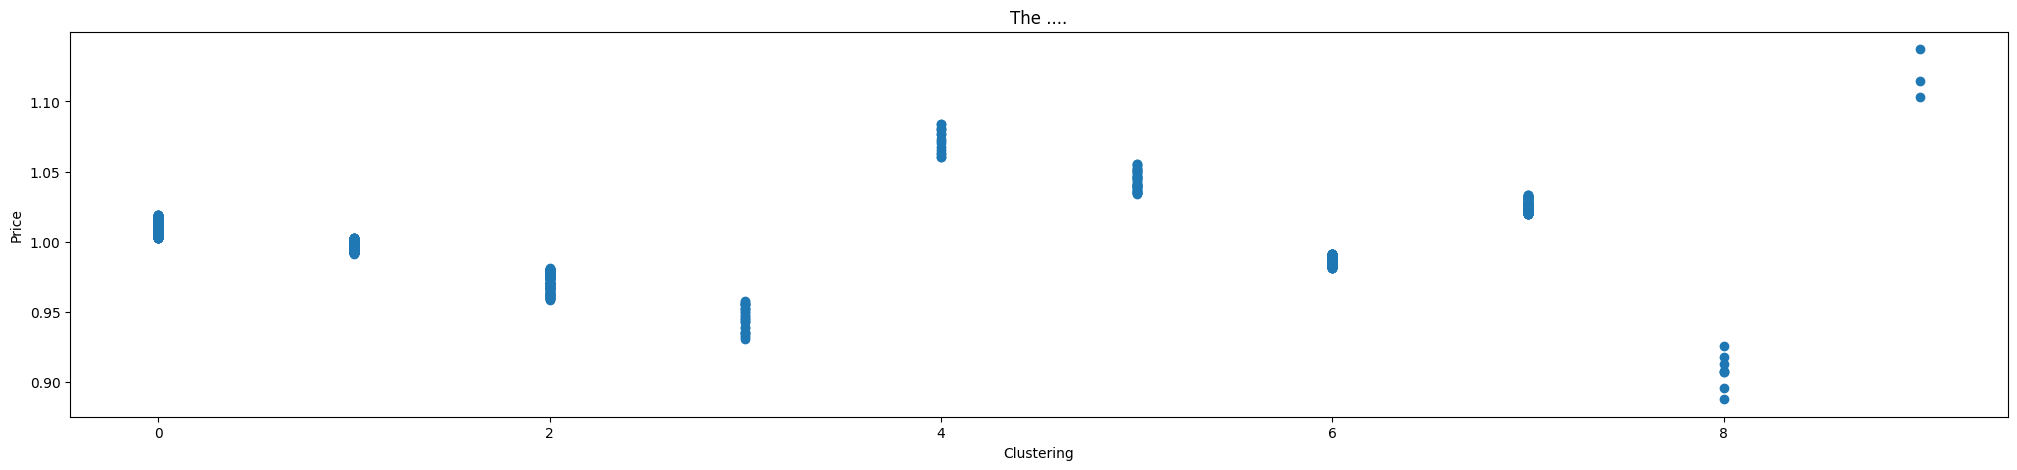

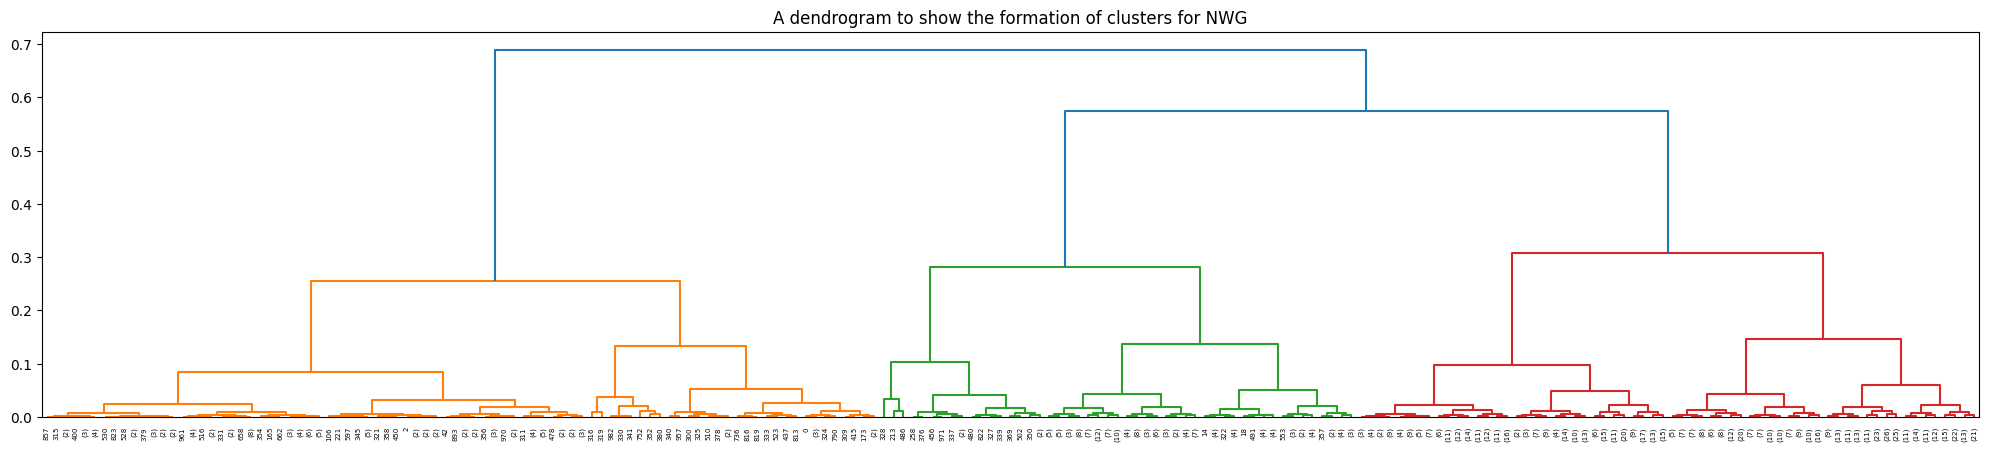

In [81]:
plotJumpClustering(train_stocks, "NWG")

In [82]:
#Example
ftse100 = []
for tick in tickers:
    ftse100.append(naiveFitMultinomialStock(train_stocks, tick, 6))

ftse100Market = Market(ftse100)
for i in range(len(train_stocks["NWG"])):
    ftse100Market.evolve()


ftse100_10jump = []
for tick in tickers:
    ftse100_10jump.append(naiveFitMultinomialStock(train_stocks, tick, 10))

ftse100_10jumpMarket = Market(ftse100_10jump)
for i in range(len(train_stocks["NWG"])):
    ftse100_10jumpMarket.evolve()


# Validation 

Select best hyperparameters for each stock model (cluster size, linkage).

Evaluate the Wasserstein distance and predict the most accurate stocks and least accurate stocks.

In [84]:
preValidationModels = {}
linkages = ["ward", "average", "complete"]
clusters = list(range(2,20))
for ticker in tickers:
    tickerModels = {}
    for clusterSize in clusters:
        for linkage in linkages:
            tickerModels[linkage+str(clusterSize)] = (naiveFitMultinomialStock(train_stocks, ticker, clusterSize, linkage))
    preValidationModels[ticker] = tickerModels

In [85]:
def calculateWassersteinDistToSample(stock, trainChanges, validateChanges):
    wd = []
    wd.append(wasserstein_distance(u_values=stock.values, v_values=trainChanges, u_weights=stock.probabilities, 
                                    v_weights=np.ones(len(trainChanges))/len(trainChanges)))
    wd.append(wasserstein_distance(u_values=stock.values, v_values=validateChanges, u_weights=stock.probabilities, 
                                    v_weights=np.ones(len(validateChanges))/len(validateChanges)))
    return wd

In [86]:
%pip install jinja2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
tickerRows = {}
tbl = []
for ticker in tickers:
    rows = []
    tblRows = {}
    trainChanges = calculateChange(train_stocks[ticker], "percentage").to_numpy()[1:]
    validateChanges = calculateChange(validate_stocks[ticker], "percentage").to_numpy()[1:]
    for model in list(preValidationModels[ticker].keys()):
        stock = preValidationModels[ticker][model]
        row = {}

        row["Model Name"] = model
        #tblRows["Stock"] = ticker
        tblRows[model] = calculateWassersteinDistToSample(stock,trainChanges,validateChanges)[1]
        row["Training Wasserstein Distance"], row["Validation Wasserstein Distance"] = calculateWassersteinDistToSample(stock,
                                                                                                                        trainChanges,
                                                                                                                        validateChanges)
        rows.append(row)
    tbl.append(tblRows)
    tickerRows[ticker] = rows

df = pd.DataFrame(tickerRows["MNG"])
table = pd.DataFrame(tbl)
pd.set_option('display.max_rows', 100)
highlighted_df = table.style.highlight_min(axis=1, color="green")
#Todo label the rows properly

display(highlighted_df)

,ward2,average2,complete2,ward3,average3,complete3,ward4,average4,complete4,ward5,average5,complete5,ward6,average6,complete6,ward7,average7,complete7,ward8,average8,complete8,ward9,average9,complete9,ward10,average10,complete10,ward11,average11,complete11,ward12,average12,complete12,ward13,average13,complete13,ward14,average14,complete14,ward15,average15,complete15,ward16,average16,complete16,ward17,average17,complete17,ward18,average18,complete18,ward19,average19,complete19
0,0.009237,0.011455,0.009683,0.007573,0.011485,0.009639,0.007049,0.011485,0.009379,0.006328,0.010506,0.008838,0.006290,0.009195,0.008838,0.005583,0.009195,0.007941,0.005583,0.008906,0.006752,0.005196,0.008906,0.006776,0.004612,0.007461,0.006776,0.004475,0.005649,0.006288,0.004475,0.005649,0.006288,0.004386,0.005649,0.005129,0.004308,0.005544,0.005024,0.004076,0.005453,0.005000,0.004044,0.005453,0.005000,0.004068,0.005453,0.004490,0.004049,0.005197,0.004490,0.004049,0.004635,0.004357
1,0.008055,0.012166,0.008520,0.006017,0.012215,0.008517,0.006043,0.012215,0.008604,0.005636,0.011343,0.008497,0.005126,0.011343,0.007908,0.005202,0.010251,0.007352,0.004113,0.010224,0.007352,0.003930,0.010224,0.007352,0.003934,0.010224,0.005677,0.003934,0.008248,0.005150,0.003738,0.008220,0.005150,0.003347,0.005997,0.005150,0.003318,0.005997,0.005150,0.003315,0.005989,0.005141,0.003139,0.004531,0.004575,0.003139,0.004412,0.004435,0.003022,0.004237,0.003468,0.002969,0.004125,0.003367
2,0.012405,0.014378,0.015228,0.012257,0.015127,0.015583,0.012323,0.015127,0.015583,0.010517,0.014504,0.012005,0.010517,0.014504,0.012005,0.010096,0.014796,0.012005,0.009802,0.014796,0.011269,0.009802,0.014796,0.011269,0.009802,0.012805,0.011269,0.009088,0.012805,0.010693,0.009088,0.012805,0.009945,0.009022,0.012805,0.009945,0.008904,0.010071,0.009945,0.008904,0.010071,0.009945,0.008904,0.010071,0.009945,0.008904,0.010042,0.009433,0.008529,0.010042,0.009433,0.008529,0.009772,0.009433
3,0.012193,0.017110,0.013523,0.009086,0.017090,0.013480,0.007870,0.017090,0.013525,0.007211,0.015181,0.009144,0.006044,0.012655,0.009159,0.006089,0.012362,0.008552,0.005938,0.012362,0.008552,0.005941,0.008434,0.008445,0.005514,0.008412,0.007709,0.005514,0.006891,0.006204,0.005337,0.006465,0.006159,0.004979,0.006465,0.005986,0.004976,0.006427,0.005449,0.004892,0.006427,0.005449,0.004684,0.005791,0.005293,0.004611,0.005791,0.005188,0.004611,0.005791,0.004865,0.004611,0.004890,0.004730
4,0.115815,0.115815,0.115815,0.116694,0.116694,0.116694,0.110313,0.116780,0.116780,0.108232,0.116776,0.115817,0.107307,0.114790,0.111748,0.107338,0.111133,0.107579,0.106338,0.111077,0.107579,0.105163,0.106945,0.107476,0.104848,0.106640,0.107240,0.104743,0.106641,0.107104,0.104158,0.105245,0.105237,0.104159,0.105015,0.105238,0.104147,0.105015,0.105238,0.104061,0.105014,0.105109,0.103917,0.104376,0.104909,0.103606,0.104376,0.104024,0.103606,0.104280,0.103811,0.103436,0.104250,0.103810
5,0.010777,0.014785,0.014322,0.009339,0.014830,0.014420,0.007118,0.014662,0.012211,0.007168,0.014246,0.012211,0.006864,0.011489,0.010597,0.006018,0.011489,0.010677,0.006018,0.010093,0.010677,0.005058,0.009938,0.007349,0.005058,0.009938,0.007248,0.004753,0.006723,0.007068,0.004614,0.006591,0.007068,0.004116,0.006591,0.005539,0.004116,0.005173,0.005539,0.004003,0.005038,0.005053,0.003869,0.005038,0.004872,0.003657,0.005042,0.004840,0.003668,0.005042,0.004301,0.003668,0.005042,0.004301
6,0.008280,0.010530,0.010530,0.007665,0.010144,0.008595,0.006386,0.009743,0.007325,0.006386,0.008320,0.007244,0.005791,0.008320,0.007143,0.005692,0.008320,0.006669,0.005174,0.008320,0.006415,0.004706,0.006885,0.006415,0.004706,0.005625,0.005194,0.004611,0.005625,0.005201,0.004582,0.005625,0.005201,0.004582,0.005495,0.005201,0.004487,0.005495,0.005191,0.004487,0.005185,0.005182,0.004348,0.004647,0.004840,0.004348,0.004647,0.004840,0.004348,0.004647,0.004509,0.004348,0.004647,0.004509
7,0.006876,0.008576,0.006795,0.005867,0.008194,0.006662,0.005348,0.008194,0.006397,0.004981,0.008194,0.

In [88]:
highestPerfModels = {}
selectedModels = {}
tolerance = 0.000001

for ticker in tickers:
    df = pd.DataFrame(tickerRows[ticker])
    minimumWD = df.min()["Validation Wasserstein Distance"]
    minimalModels = df.where(df["Validation Wasserstein Distance"]<=minimumWD+tolerance).dropna()

    minimalLowestComplexityModel = minimalModels.iloc[0]["Model Name"]
    
    highestPerfModels[ticker] = preValidationModels[ticker][minimalLowestComplexityModel]
    selectedModels[ticker] = minimalLowestComplexityModel

In [89]:
#Create market from stocks


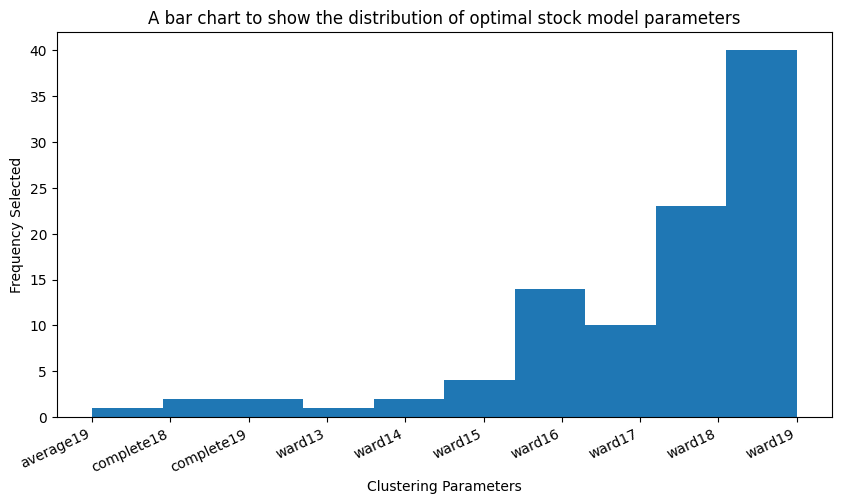

In [141]:
modelTypes = []
for ticker in tickers:
    #Ward2 is likely an error with incorrect collected data
    if not (selectedModels[ticker] == "ward2"):
        modelTypes.append(selectedModels[ticker])
modelTypes.sort()
plt.title("A bar chart to show the distribution of optimal stock model parameters")
plt.hist(modelTypes)
plt.ylabel("Frequency Selected")
plt.xlabel("Clustering Parameters")

plt.rcParams["figure.figsize"] = (10,5)
plt.xticks(rotation=25, ha='right')

plt.savefig("Images/Model-Validation-Params.svg")

plt.show()

# Test

- Comparision of Wasserstein distances (model vs sample), rank order the stocks.

- Comparision of variances (100 runs, variance over each run)

- Comparision of market returns??

- Autocorrelation of sample (models at the momement have zero autocorrelation)

In [91]:
#for i in range(len(tickers)):
#    wd = someDist(np.array(ftse100Market.history)[:,i], stocks[tickers[i]]["Price"])

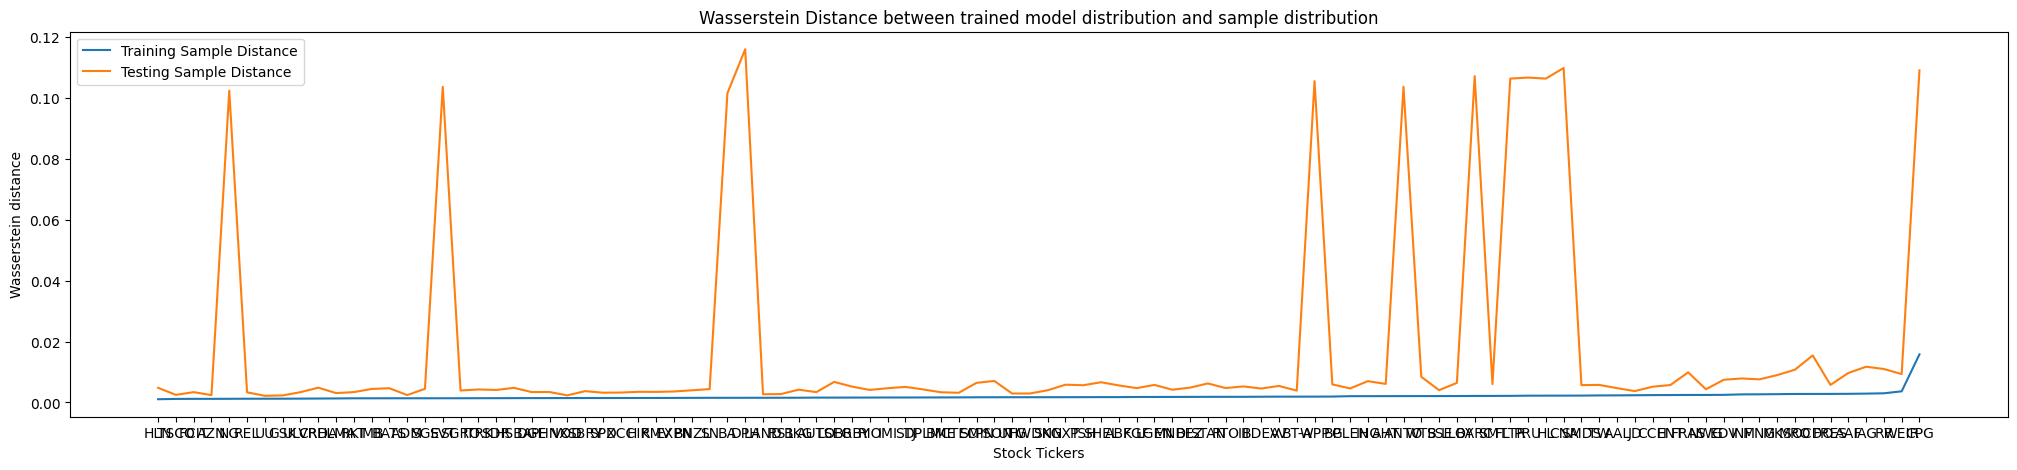

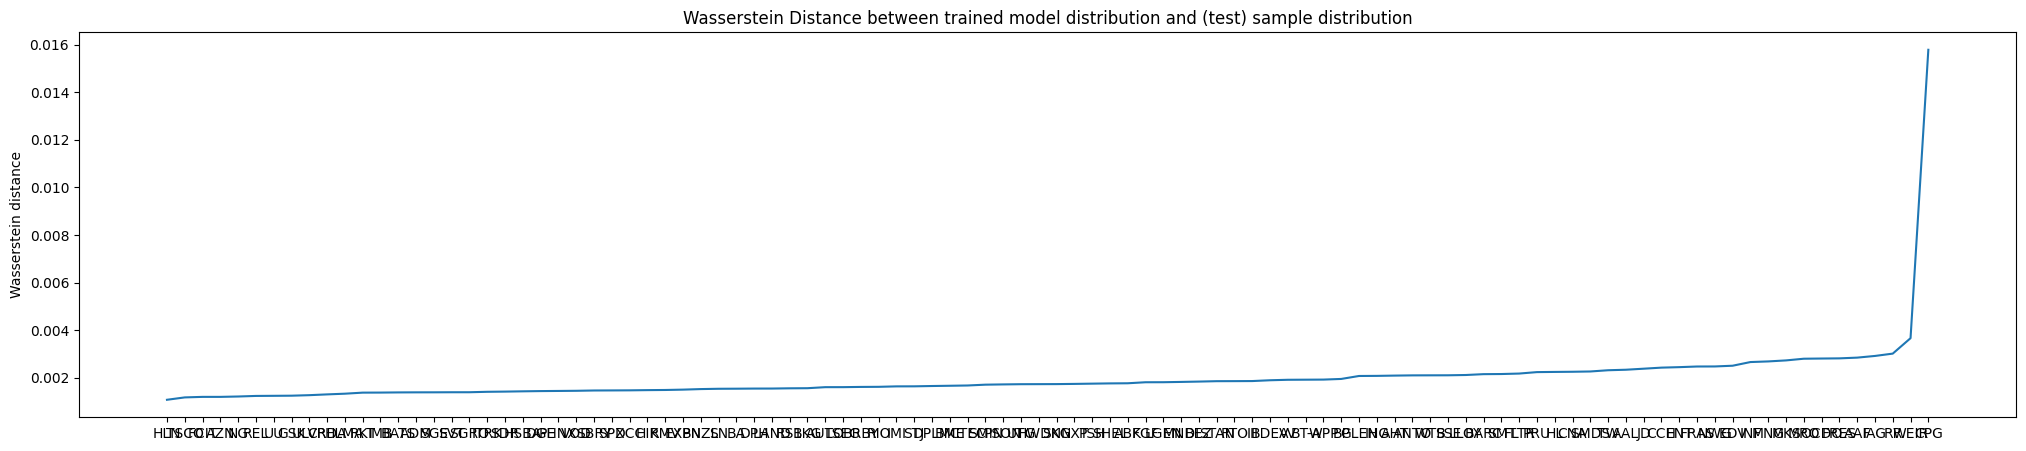

The following stock models have a significantly poorer Wasserstein distance compared to the rest of the group
['NG', 'SVT', 'BA', 'DPH', 'WPP', 'ANTO', 'BARC', 'FLTR', 'PRU', 'HL', 'CNA', 'MRO', 'OCDO', 'IAG', 'RR', 'CPG']


In [125]:
#Issues with scale??
trainWd = []
testWd = []
for i in range(len(tickers)):
    stock = highestPerfModels[tickers[i]]
    #realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    trainSample = calculateChange(train_stocks[tickers[i]], "percentage").to_numpy()[1:]
    testSample = calculateChange(test_stocks[tickers[i]], "percentage").to_numpy()[1:]
    trainWd.append([wasserstein_distance(u_values=stock.values, v_values=trainSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(trainSample))/len(trainSample)), tickers[i]])
    
    testWd.append([wasserstein_distance(u_values=stock.values, v_values=testSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(testSample))/len(testSample)), tickers[i]])

def distSort(e):
    return float(e[0])

trainWd.sort(key=distSort)
trainTickers = []
trainDistances = []
testDistances = []
poorFits = []

for item in trainWd:
    trainTickers.append(item[1])
    trainDistances.append(item[0])
    for testIt in testWd:
        if testIt[1] == item[1]:
            validationDist = testIt[0]
            testDistances.append(validationDist)
            if validationDist >= 0.01:
                poorFits.append(item[1])
    
plt.title("Wasserstein Distance between trained model distribution and sample distribution")
plt.ylabel("Wasserstein distance")
plt.xlabel("Stock Tickers")
plt.plot(trainTickers, trainDistances, label= "Training Sample Distance")
plt.plot(trainTickers, testDistances, label = "Testing Sample Distance")
plt.legend()
plt.savefig("Images/WD-Model-Testing.svg")
plt.show()

#MOVE
plt.title("Wasserstein Distance between trained model distribution and (test) sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(trainTickers, trainDistances)
plt.show()
#END MOVE

print("The following stock models have a significantly poorer Wasserstein distance compared to the rest of the group")
print(poorFits)

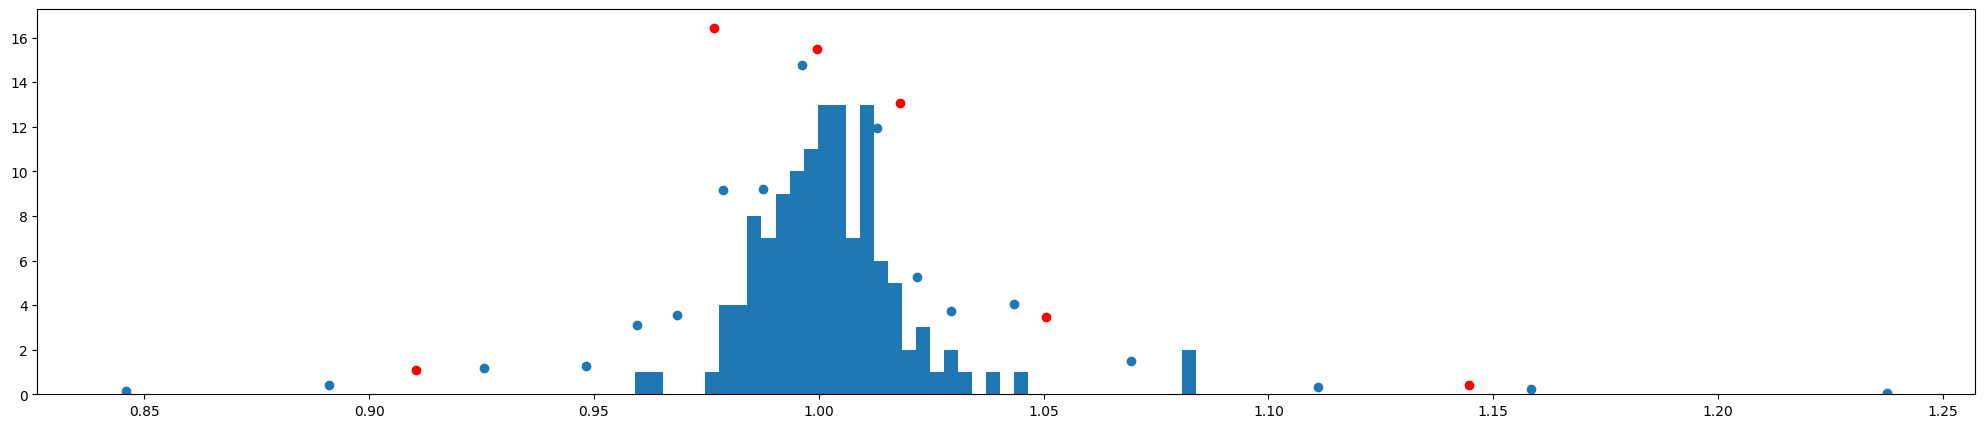

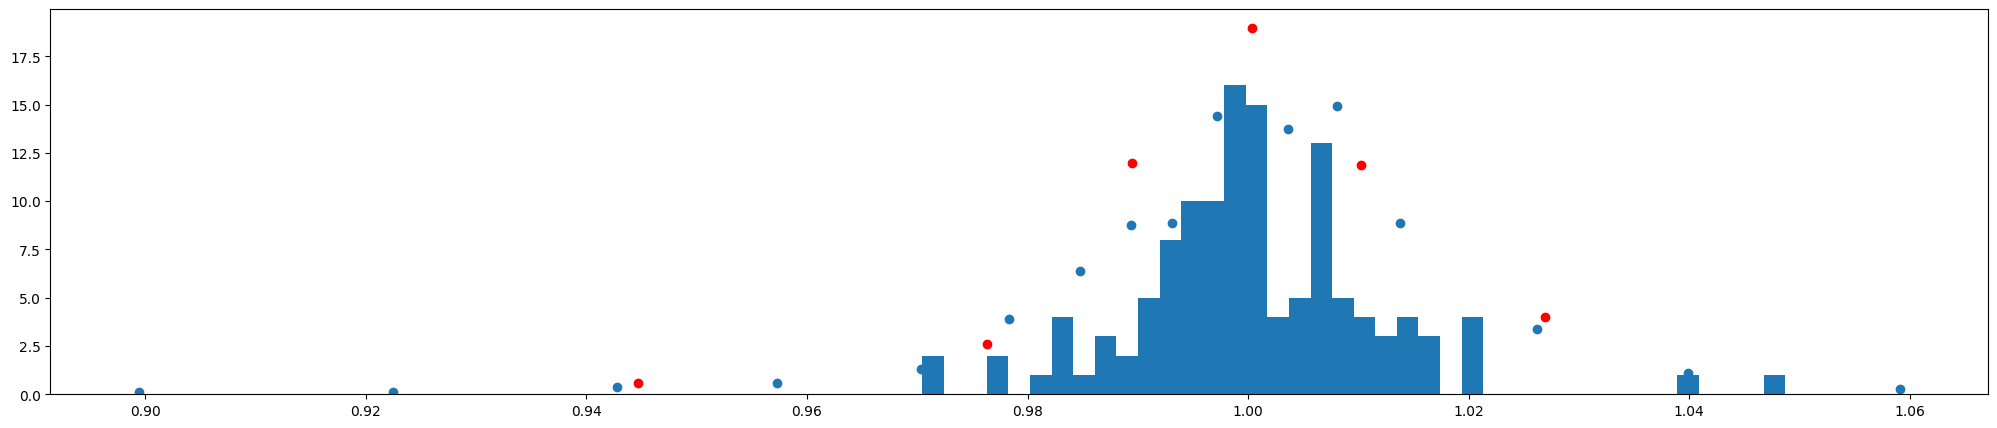

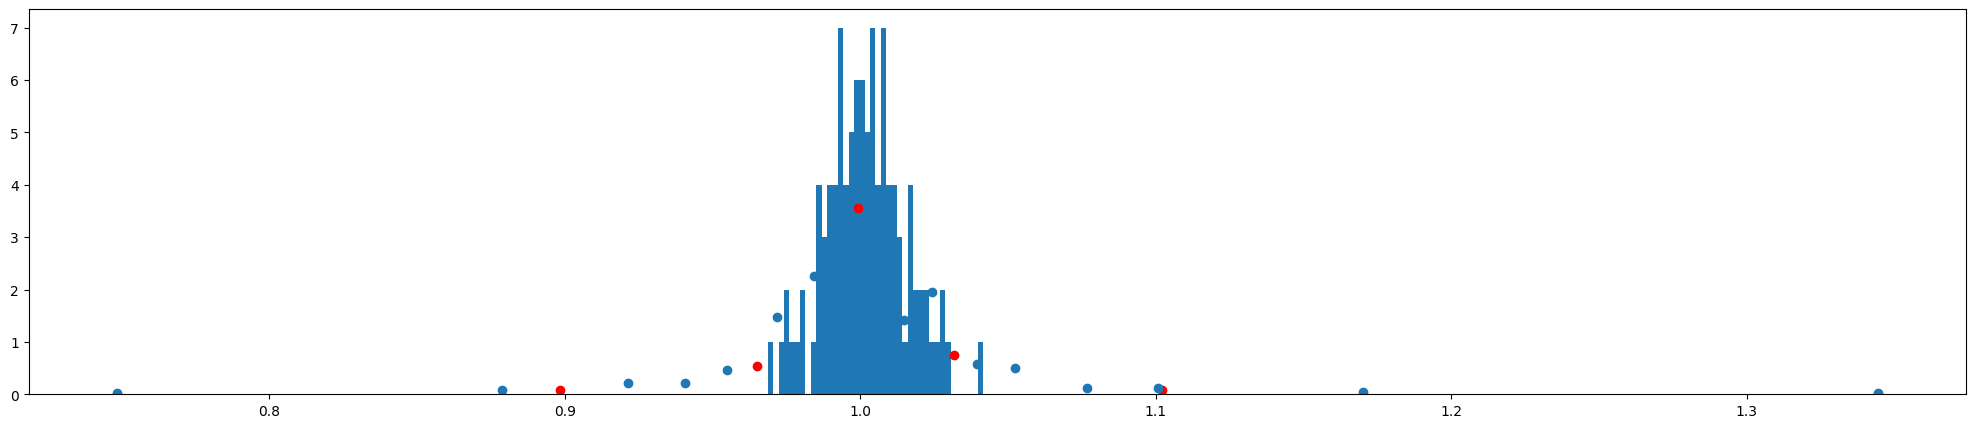

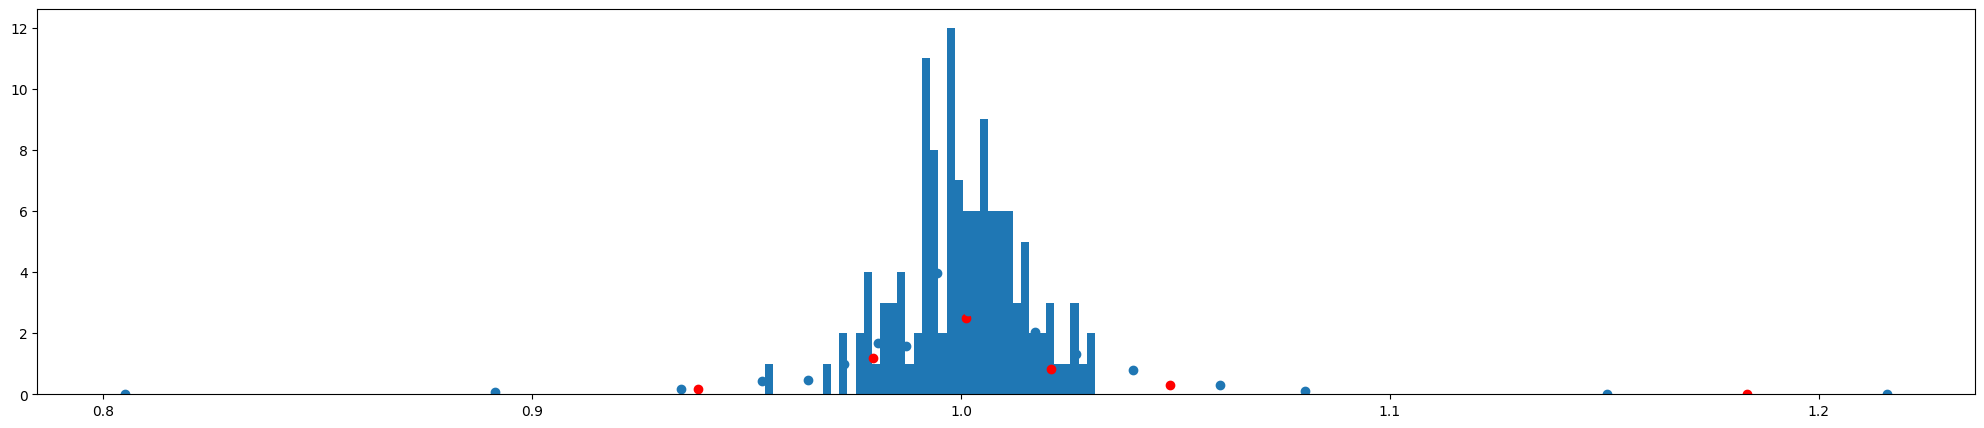

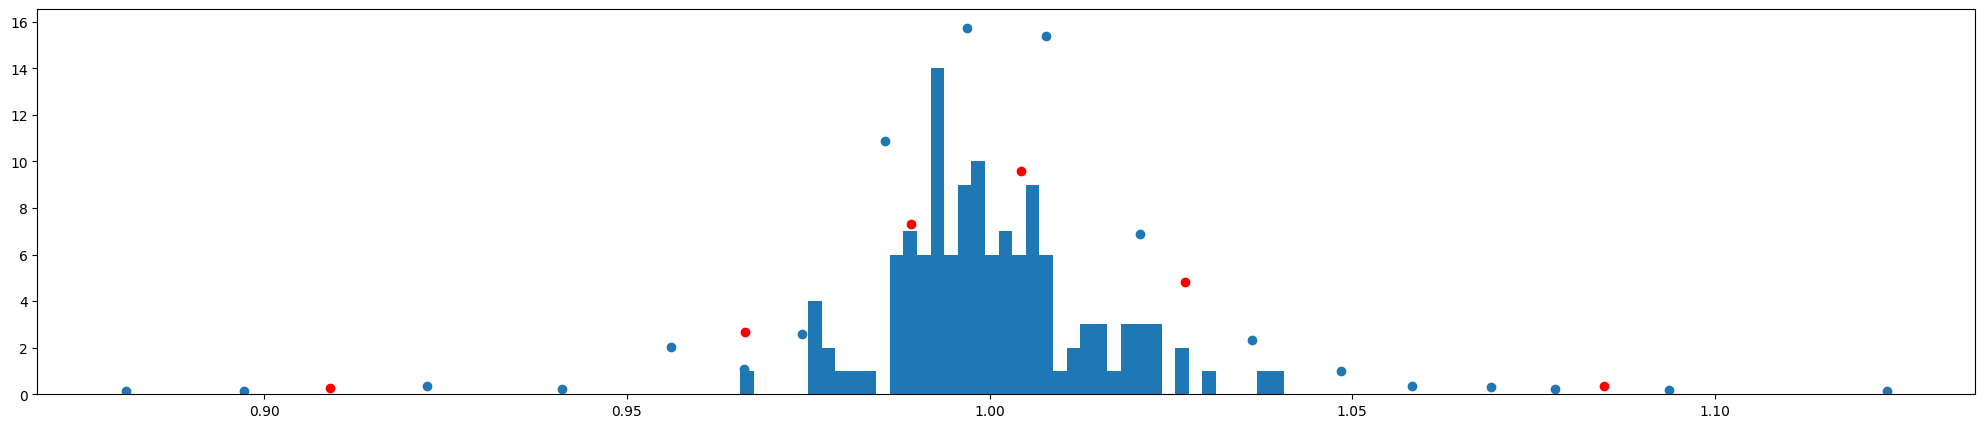

In [93]:
plt.hist(calculateChange(test_stocks["MKS"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "MKS":
        stock = ftse100Market.assets[i]
        extraStock = preValidationModels["MKS"]["ward18"]
        plt.scatter(extraStock.values, np.array(extraStock.probabilities)*80)
        plt.scatter(stock.values, np.array(stock.probabilities)*50, c="red")
        plt.show()


plt.hist(calculateChange(test_stocks["GSK"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "GSK":
        stock = ftse100Market.assets[i]
        plt.scatter(stock.values, np.array(stock.probabilities)*50, c="red")
        extraStock = preValidationModels["GSK"]["ward18"]
        plt.scatter(extraStock.values, np.array(extraStock.probabilities)*100)
        plt.show()


plt.hist(calculateChange(test_stocks["MNG"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "MNG":
        stock = ftse100Market.assets[i]
        plt.scatter(stock.values, np.array(stock.probabilities)*5, c="red")
        extraStock = preValidationModels["MNG"]["ward18"]
        plt.scatter(extraStock.values, np.array(extraStock.probabilities)*20)
        plt.show()



plt.hist(calculateChange(test_stocks["BP"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "BP":
        stock = ftse100Market.assets[i]
        plt.scatter(stock.values, np.array(stock.probabilities)*5, c="red")
        extraStock = preValidationModels["BP"]["ward18"]
        plt.scatter(extraStock.values, np.array(extraStock.probabilities)*20)
        plt.show()

plt.hist(calculateChange(test_stocks["LLOY"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "LLOY":
        stock = ftse100Market.assets[i]
        plt.scatter(stock.values, np.array(stock.probabilities)*25, c="red")
        extraStock = preValidationModels["LLOY"]["complete18"]
        plt.scatter(extraStock.values, np.array(extraStock.probabilities)*60)
        plt.show()

In [131]:
# Welch's t-test
import scipy as scp
scp.stats.ttest_ind
def generatePCSample(stock, n):
    pc = []
    previousPrice = stock.initialValue
    for _ in range(n):
        stock.evolve()
        pc.append(stock.value /previousPrice)
        previousPrice = stock.value
    return pc


print("Welch's t test (a modified version of the popular student t-test without the underlying assumption of equal sample variances)\n")
print("H0: the means of the distributions the samples were generated from are equal")
print("H1: the means of the distributions the samples were generated from are unequal\n")

for tick in tickers:
    modelSample = generatePCSample(highestPerfModels[tick], 10000)
    testSample = calculateChange(test_stocks[tick], "abs")
    welch_t_test = scp.stats.ttest_ind(modelSample, testSample,equal_var=False)
    if (welch_t_test.pvalue <= 0.05):
        print(f"Reject the null hypothesis at the 5pc level for {tick}")
        print(welch_t_test.pvalue)
        print("")

Welch's t test (a modified version of the popular student t-test without the underlying assumption of equal sample variances)

H0: the means of the distributions the samples were generated from are equal
H1: the means of the distributions the samples were generated from are unequal

Reject the null hypothesis at the 5pc level for BT-A
8.015865301787782e-10

Reject the null hypothesis at the 5pc level for CNA
0.00010325917397413249

Reject the null hypothesis at the 5pc level for IAG
0.000213387249089648

Reject the null hypothesis at the 5pc level for PRU
0.03714177494633987

Reject the null hypothesis at the 5pc level for SBRY
0.003112504251391699

Reject the null hypothesis at the 5pc level for SMDS
0.005118576619590843

Reject the null hypothesis at the 5pc level for TW
9.686180985563286e-07

Reject the null hypothesis at the 5pc level for VOD
4.1149659488662764e-20



# Current limitations:
- We assume that we can model stock prices such that the percentage changes are stationary - test this
- No cross vailidation
- Quality of fit or statistical significance is missing.
- Comparing variances might be intersting, as well as the ability.
- Find the optimial clusters for clustering - 

Todo
- Look at cross validation for current clustering results
+- Statistical tests - find if any significant, or most accurate models
